# Tutorial 1e - Non-Rotationally Symmetric Systems

This tutorial demonstrates how to correctly setup a system for which there is no rotational symmetry using Optiland, e.g. folding mirror in a binocular design, or scanning lenses.

The following topics will be covered:

1. Surface Coordinate System in Optiland.
2. Folded Mirror System Design in Optiland - Approach 1 (more intuitive)

    2.1 Simple RMS Spot Optimization.

3. Folded Mirror System Design in Optiland - Approach 2 (less intuitive).


### February 2025

In [1]:
import numpy as np

from optiland import analysis, optic, optimization

**1. Surface Coordinate System in Optiland**

In rotationally symmetric systems, all the surfaces are typically aligned along the z-axis (so-called optical axis), and passing the `thickness` parameter to the `optic.add_surface()` method will simply specify the distance between the consecutive surfaces. <br>
However, in a non-rotationally symmetric system, the surfaces are not necessarily aligned along the z-axis. To represent this, the surface coordinate system in Optiland includes two additional axes, `x` and `y`. The `x` axis is perpendicular to the optical axis and points in the direction 'inside the screen'. The `y` axis is perpendicular to the optical axis and points in the upwards direction.

**2. Folded Mirror System Design - Approach 1 (more intuitive)**

An overview of the design task can be found in the following image:

![diagram](../images/tutorial_1e_diagram.png)

To design this folded mirror system, you need to consider the following:

 - To rotate a surface (say, tilt about the x axis), you need to pass the parameter `rx=...` in the `add_surface()` method. The same applies to the tilt about Y or tilt about Z, and their corresponding parameters are ry, and rz, respectively. The default units of rotation of a surface are radians, which means that if you prefer to specify the rotation in degrees, you must use, for example for a 45 degree rotation about X, the parameter `rx=np.radians(45)`. 
 - You must not pass `thickness` after defining an `x`, `y`, `z` position for a previous surface. Hence, if you want to design systems with coordinate breaks, the best approach is to always specify the location of the surfaces using their (x,y,z) coordinates, instead of `thickness`.



In [2]:
lens = optic.Optic()

# System settings
lens.set_aperture(aperture_type="EPD", value=5.0)
lens.set_field_type(field_type="angle")
lens.add_field(y=-0.5)
lens.add_field(y=0)
lens.add_field(y=0.5)
lens.add_wavelength(value=0.633, is_primary=True)

# Lens data
lens.add_surface(index=0, radius=np.inf, z=-np.inf)
lens.add_surface(index=1, z=0)
lens.add_surface(index=2, z=10, material="bk7", surface_type="standard")  # material in
lens.add_surface(index=3, z=15, material="air", surface_type="standard")  # material out
lens.add_surface(
    index=4, z=25, material="mirror", rx=-np.pi / 4, is_stop=True
)  # first mirror
lens.add_surface(
    index=5, z=25, y=-15, material="mirror", rx=-np.pi / 4
)  # second mirror
lens.add_surface(index=6, z=45, y=-15, material="mirror", rx=np.pi / 4)  # third mirror
lens.add_surface(
    index=7, z=45, y=-10, radius=-30, material="bk7", rx=np.pi / 2
)  # material in
lens.add_surface(
    index=8, z=45, y=-5, radius=30, material="air", rx=np.pi / 2
)  # material out
lens.add_surface(index=9, z=45, y=10, material="mirror", rx=np.pi / 4)  # fourth mirror
lens.add_surface(index=10, z=55, y=10)  # Image plane

Note how we define the translation parameters (e.g. x, y, z) and the rotation parameters (e.g. rx, ry, rz) for each surface.
Note also, how we must rotate the surfaces of the last focusing lens (surfaces 7 and 8) in order to meet the correct ray propagation direction. In fact, you can try yourself, that if you forget to rotate this surfaces, some of the ray computations will fail, because it will be assumed that the surface is still in the origin coordinate system (i.e. with rx=0)

We can then visualize both the 2D and 3D drawings of the system we have just designed:

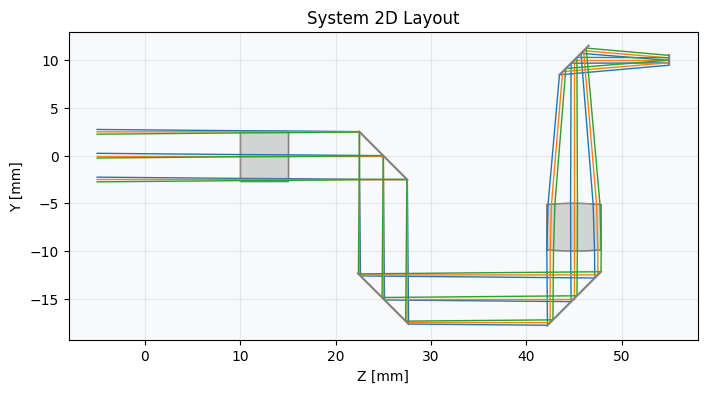

In [3]:
lens.draw(title="System 2D Layout")
lens.draw3D(num_rays=10)  # Opens in external window when you run the code

And we can check its spot diagram (before optimization) as well:

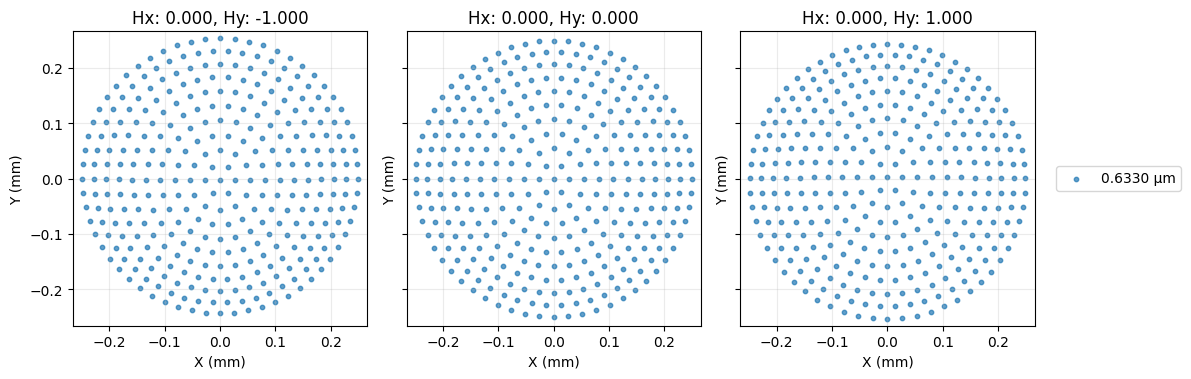

In [4]:
spot = analysis.SpotDiagram(lens, num_rings=10, distribution="hexapolar")
spot.view()

**2.1 Fine tuning optimization for best focus in the image plane - Simple RMS Spot Optimization**

Once the design is finished, we see that the system is still not in the best focus. This means that a simple optimization can be used to optimize the distance from the last surface of the system (i.e. the back surface of the focusing lens) to the image plane (surface index 9). 

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │             0.00643671 │           99.9334 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │       10 │   0.005 │   0.005 │          35.94 │
│  1 │ rms spot size  │        0 │              │              │       10 │   0.004 │   0.004 │          28.13 │
│  2 │ rms spot size  │        0 │              │              │       10 │   0.005 │   0.005 │          35.94 │
╘════╧════════════════╧══════════╧══════════════╧═════════════

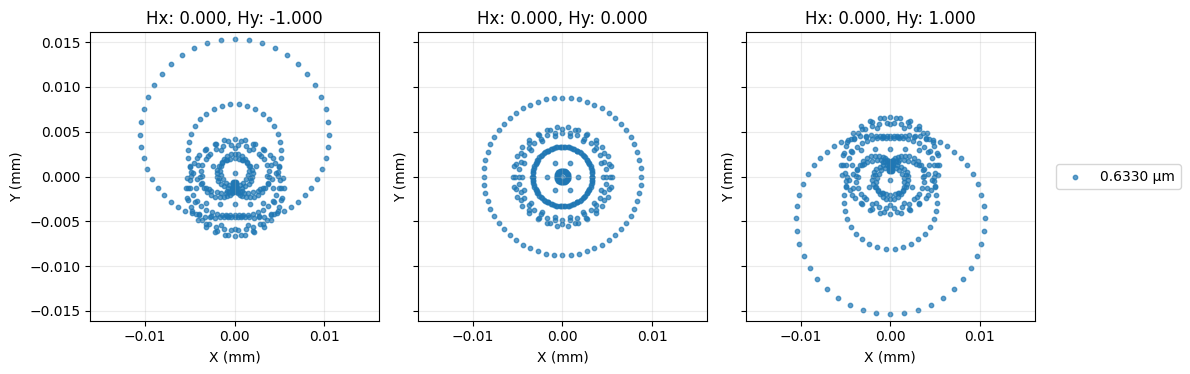

In [5]:
problem = optimization.OptimizationProblem()

# Variable Definition
# thicknesses
problem.add_variable(lens, "thickness", surface_number=9, min_val=10, max_val=20)

# RMS spot size - let's minimize the spot size for each field at the primary wavelength.
# We choose a 'uniform' distribution, so the number of rays actually means the rays
# along one axis.
for field in lens.fields.get_field_coords():
    input_data = {
        "optic": lens,
        "surface_number": -1,
        "Hx": field[0],
        "Hy": field[1],
        "num_rays": 16,
        "wavelength": 0.633,
        "distribution": "uniform",
    }
    problem.add_operand(
        operand_type="rms_spot_size",
        target=0.0,
        weight=10,
        input_data=input_data,
    )

# Local optimizer
optimizer = optimization.OptimizerGeneric(problem)
optimizer.optimize()
problem.info()

# Final spot diagram
spot = analysis.SpotDiagram(lens, num_rings=10, distribution="hexapolar")
spot.view()

**3. Folded Mirror System Design in Optiland - Approach 2 (less intuitive)**

In this approach, we make use of the `thickness` parameter, though now we define decenters with their corresponding parameters dx, dy (decenters in x, and y, respectively).
<br>
Comparing this method with the first approach, if we want to rotate the first mirror, we use the same rx parameter as before, but we set its thickness to 0, and in the next added surface, the translation happens in the y-axis (due to the downard-direction reflection at the mirror), and therefore we should locate the second mirror by passing the parameter `dy=-15`. Because the second mirror changes once again the direction of the rays (they propagate once more in the +z direction), we set the parameter `thickness=20` in this second mirror surface, to say that "the distance (z) from this mirror to the next surface is 20 mm". And so on...

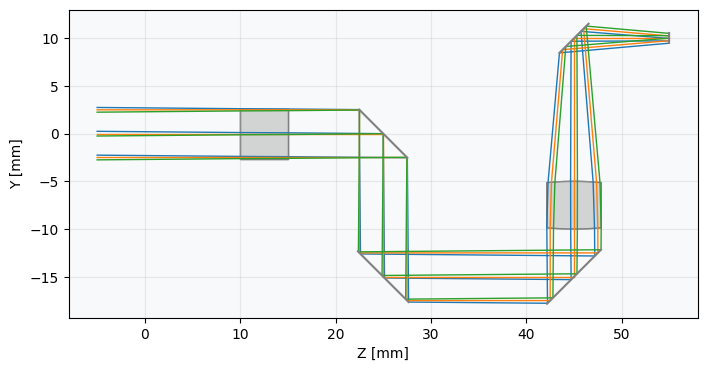

In [6]:
lens2 = optic.Optic()

lens2.add_surface(index=0, radius=np.inf, thickness=-np.inf)
lens2.add_surface(index=1, thickness=10)
lens2.add_surface(
    index=2, thickness=5, material="bk7", surface_type="standard"
)  # material in
lens2.add_surface(
    index=3, thickness=10, material="air", surface_type="standard"
)  # material out
lens2.add_surface(
    index=4, thickness=0, material="mirror", rx=-np.pi / 4, is_stop=True
)  # first mirror
lens2.add_surface(
    index=5, thickness=20, dy=-15, material="mirror", rx=-np.pi / 4
)  # second mirror
lens2.add_surface(
    index=6, thickness=0, dy=-15, material="mirror", rx=np.pi / 4
)  # third mirror
lens2.add_surface(
    index=7, thickness=0, dy=-10, radius=-30, material="bk7", rx=np.pi / 2
)  # material in
lens2.add_surface(
    index=8, thickness=0, dy=-5, radius=30, material="air", rx=np.pi / 2
)  # material out
lens2.add_surface(
    index=9, thickness=10, dy=10, material="mirror", rx=np.pi / 4
)  # fourth mirror
lens2.add_surface(index=10, dy=10)  # Image plane

# System Settings
lens2.set_aperture(aperture_type="EPD", value=5.0)
lens2.set_field_type(field_type="angle")
lens2.add_field(y=-0.5)
lens2.add_field(y=0)
lens2.add_field(y=0.5)
lens2.add_wavelength(value=0.633, is_primary=True)

# visulaize the system
lens2.draw()
lens2.draw3D(num_rays=10)

**Conclusion:** <br>
We have explored the surfaces' coordinate systems in Optiland, as well as providing two approaches to design complex optical systems which involve several changes in coordinates, as it happens with folding mirrors. The first approach presents itself as a more intuitive method, since we are effectively localizing each surface according to its coordinate system in the 3D space. The second approach, however, involves considering that after folding mirrors, the translation happens in another axis and special care is needed to ensure the correct modelling of the system. 